In [1]:
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile

def get_sin_oscillator(freq, amp=1, phase=0, sample_rate=44100):
    phase = (phase / 360) * 2 * math.pi
    
    increment = (2 * math.pi * freq)/ sample_rate
    
    return (math.sin(phase + v) * amp for v in itertools.count(start=0, step=increment))

## Функция

[0.984807753012208, 0.971994492787488, 0.9553625858539904, 0.9349773735044321, 0.9109189425341849, 0.8832818106065943, 0.8521745549241634, 0.8177193856644315, 0.7800516658563768, 0.7393193795835922]


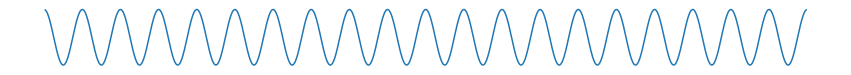

In [2]:
sample_rate = 44100
freq = 440


osc = get_sin_oscillator(freq, amp=1, phase=100)
samples = [next(osc) for i in range(sample_rate)]
print(samples[:10])
figure = plt.figure(figsize=(15, 20))
plt.subplot(15, 1, 1)
plt.axis('off')
plt.plot(samples[:2000])

Audio(samples, rate=sample_rate)



## Осцилятор

In [3]:
from abc import ABC, abstractmethod
import osc
import utils

Oscillator = osc.Oscillator
    
class SineOscillator(Oscillator):
    def _post_freq_set(self):
        self._step = (2 * math.pi * self._f) / self._sample_rate
        
    def _post_phase_set(self):
        self._p = (self._p / 360) * 2 * math.pi
        
    def _initialize_osc(self):
        self._i = 0
        
    def __next__(self):
        val = math.sin(self._i + self._p)
        self._i = self._i + self._step
        if self._wave_range is not (-1, 1):
            val = self.squish_val(val, *self._wave_range)
        return val * self._a
    
    
class SawtoothOscillator(Oscillator):
    def _post_freq_set(self):
        self._period = self._sample_rate / self._f
        self._post_phase_set
        
    def _post_phase_set(self):
        self._p = ((self._p + 90)/ 360) * self._period
    
    def _initialize_osc(self):
        self._i = 0
    
    def __next__(self):
        div = (self._i + self._p )/self._period
        val = 2 * (div - math.floor(0.5 + div))
        self._i = self._i + 1
        if self._wave_range is not (-1, 1):
            val = self.squish_val(val, *self._wave_range)
        return val * self._a

    
class WaveAdder:
    def __init__(self, *oscillators):
        self.oscillators = oscillators
        self.n = len(oscillators)
    
    def __iter__(self):
        [iter(osc) for osc in self.oscillators]
        return self
    
    def __next__(self):
        return sum(next(osc) for osc in self.oscillators) / self.n
    



<>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:40: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:76: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:40: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:76: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/6s/_31kgkdx7gd2mmz74zjgfdjm0000gn/T/ipykernel_7529/2005754050.py:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self._wave_range is not (-1, 1):
/var/folders/6s/_31kgkdx7gd2mmz74zjgfdjm0000gn/T/ipykernel_7529/2005754050.py:40: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self._wave_range is not (-1, 1):
/var/folders/6s/_31kgkdx7gd2mmz74zjgfdjm0000gn/T/ipykernel_7529/2005754050.py:76: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self._wave_range is not (-1, 1):


## Модулятор

In [8]:
class ADSREnvelope:
    def __init__(self, attack_duration=0.05, decay_duration=0.2, sustain_level=0.7, \
                 release_duration=0.3, sample_rate=44100):
        self.attack_duration = attack_duration
        self.decay_duration = decay_duration
        self.sustain_level = sustain_level
        self.release_duration = release_duration
        self._sample_rate = sample_rate
        
    def get_ads_stepper(self):
        steppers = []
        if self.attack_duration > 0:
            steppers.append(itertools.count(start=0, \
                step= 1 / (self.attack_duration * self._sample_rate)))
        if self.decay_duration > 0:
            steppers.append(itertools.count(start=1, \
            step=-(1 - self.sustain_level) / (self.decay_duration  * self._sample_rate)))
        while True:
            l = len(steppers)
            if l > 0:
                val = next(steppers[0])
                if l == 2 and val > 1:
                    steppers.pop(0)
                    val = next(steppers[0])
                elif l == 1 and val < self.sustain_level:
                    steppers.pop(0)
                    val = self.sustain_level
            else:
                val = self.sustain_level
            yield val
    
    def get_r_stepper(self):
        val = 1
        if self.release_duration > 0:
            release_step = - self.val / (self.release_duration * self._sample_rate)
            stepper = itertools.count(self.val, step=release_step)
        else:
            val = -1
        while True:
            if val <= 0:
                self.ended = True
                val = 0
            else:
                val = next(stepper)
            yield val
    
    def __iter__(self):
        self.val = 0
        self.ended = False
        self.stepper = self.get_ads_stepper()
        return self
    
    def __next__(self):
        self.val = next(self.stepper)
        return self.val
        
    def trigger_release(self):
        self.stepper = self.get_r_stepper()
        
        
        
class ModulatedOscillator:
    def __init__(self, oscillator, *modulators, amp_mod=None, freq_mod=None, phase_mod=None):
        self.oscillator = oscillator
        self.modulators = modulators # list
        self.amp_mod = amp_mod
        self.freq_mod = freq_mod
        self.phase_mod = phase_mod
        self._modulators_count = len(modulators)
    
    def __iter__(self):
        iter(self.oscillator)
        [iter(modulator) for modulator in self.modulators]
        return self
    
    def _modulate(self, mod_vals):
        if self.amp_mod is not None:
            new_amp = self.amp_mod(self.oscillator.init_amp, mod_vals[0])
            self.oscillator.amp = new_amp
            
        if self.freq_mod is not None:
            if self._modulators_count == 2:
                mod_val = mod_vals[1]
            else:
                mod_val = mod_vals[0]
            new_freq = self.freq_mod(self.oscillator.init_freq, mod_val)
            self.oscillator.freq = new_freq
            
        if self.phase_mod is not None:
            if self._modulators_count == 3:
                mod_val = mod_vals[2]
            else:
                mod_val = mod_vals[-1]
            new_phase = self.phase_mod(self.oscillator.init_phase, mod_val)
            self.oscillator.phase = new_phase
    
    def trigger_release(self):
        tr = "trigger_release"
        for modulator in self.modulators:
            if hasattr(modulator, tr):
                modulator.trigger_release()
        if hasattr(self.oscillator, tr):
            self.oscillator.trigger_release()
            
    @property
    def ended(self):
        e = "ended"
        ended = []
        for modulator in self.modulators:
            if hasattr(modulator, e):
                ended.append(modulator.ended)
        if hasattr(self.oscillator, e):
            ended.append(self.oscillator.ended)
        return all(ended)

    def __next__(self):
        mod_vals = [next(modulator) for modulator in self.modulators]
        self._modulate(mod_vals)
        return next(self.oscillator)

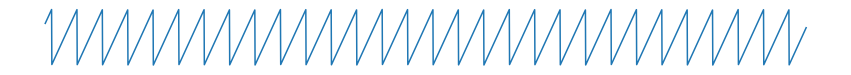

In [9]:
sample_rate =44100

gen1 = WaveAdder(
    SawtoothOscillator(freq=440,phase=0),
#     SineOscillator(freq=440,phase=100),
#     TriangleOscillator(freq=220, amp=0.8),
#     SawtoothOscillator(freq=400, amp=0.6),
#     SquareOscillator(freq=55, amp=0.4),
)
    
iter(gen1)
wav = [next(gen1) for _ in range(sample_rate * 4)] # 4 Seconds

figure = plt.figure(figsize=(15, 20))
plt.subplot(15, 1, 1)
plt.axis('off')
plt.plot(wav[:3000])

Audio(wav, rate=sample_rate)
# utils.wave_to_file(wav, fname="prelude_one.wav")